In [1]:
import numpy as np
import pandas as pd

from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel

import networkx as nx
import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt


In [2]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

from sklearn.metrics import (
    normalized_mutual_info_score,
    homogeneity_completeness_v_measure,
    fowlkes_mallows_score,
    adjusted_rand_score
)
from itertools import combinations

In [3]:
import warnings
warnings.filterwarnings('ignore')

## GCS-Q Algorithm

In [ ]:
# # Step 1: Construct the initial graph from the adjacency matrix
# def construct_graph(adj_matrix):
#     G = nx.Graph()
#     num_nodes = len(adj_matrix)
#     for i in range(num_nodes):
#         for j in range(i + 1, num_nodes):
#             if adj_matrix[i][j] != 0:
#                 G.add_edge(i, j, weight=adj_matrix[i][j])
#     return G

# # Step 2: Define the function to calculate coalition value (sum of weights)
# def coalition_value(subgraph):
#     return subgraph.size(weight='weight')


# def get_qubo_matrix(W):
#     """Computes the QUBO matrix for the Minimum Cut problem given a weight matrix W."""
#     n = W.shape[0]  # Number of nodes
#     Q = np.zeros((n, n))  # Initialize QUBO matrix
    
#     for i in range(n):
#         Q[i, i] = np.sum(W[i])  # Diagonal terms (degree of node)
#         for j in range(n):
#             if i != j:
#                 Q[i, j] = -W[i, j]  # Off-diagonal terms (negative adjacency)
    
#     return Q

# # Step 3: Bipartitioning using QUBO and Quantum Annealing
# def bipartition(graph):
#     if len(graph.nodes())==1:
#        return [], [0], 0

#     w = nx.adjacency_matrix(graph).todense()
#     qubo = get_qubo_matrix(W = w)

#     bqm = BinaryQuadraticModel.from_qubo(qubo)

#     sampler = EmbeddingComposite(DWaveSampler(token = open('dwave-api-token.txt','r').read(), solver={'topology__type': 'pegasus'}))
#     sampleset = sampler.sample(bqm, num_reads=1000)
#     qpu_access_time = sampleset.info['timing']['qpu_access_time']

#     solution = sampleset.first.sample
#     partition1 = [node for node in solution if solution[node] == 1]
#     partition2 = [node for node in solution if solution[node] == 0]

#     return partition1, partition2, qpu_access_time

# def gurobi_qubo_solver_old(linear,quadratic):
#     qubo_matrix = np.zeros([len(linear),len(linear)])
#     for key,value in linear.items():
#         qubo_matrix[int(key),int(key)] = value
#     for key,value in quadratic.items():
#         qubo_matrix[int(key[0]),int(key[1])] = value/2
#         qubo_matrix[int(key[1]),int(key[0])] = value/2
#     n = qubo_matrix.shape[0]
#     model = gp.Model()
#     x = model.addVars(n, vtype=GRB.BINARY)
#     obj_expr = gp.quicksum(qubo_matrix[i, j] * x[i] * x[j] for i in range(n) for j in range(n))
#     model.setObjective(obj_expr)
#     model.setParam('OutputFlag', 0)
#     model.optimize()
#     if model.status == GRB.OPTIMAL:
#         solution = [int(x[i].X) for i in range(n)]
#         binary_string = ''.join(str(bit) for bit in solution)
#         return binary_string, model.objVal
#     else:
#         return None, None

# def gurobi_qubo_solver(qubo_matrix):
#     n = qubo_matrix.shape[0]
#     model = gp.Model()
#     x = model.addVars(n, vtype=GRB.BINARY)
#     obj_expr = gp.quicksum(qubo_matrix[i, j] * x[i] * x[j] for i in range(n) for j in range(n))
#     model.setObjective(obj_expr)
#     model.setParam('OutputFlag', 0)
#     model.optimize()
#     if model.status == GRB.OPTIMAL:
#         solution = [int(x[i].X) for i in range(n)]
#         binary_string = ''.join(str(bit) for bit in solution)
#         return binary_string, model.objVal
#     else:
#         return None, None

# # Step 3: Bipartitioning using QUBO and Quantum Annealing
# def bipartition_gurobi(graph):
#     if len(graph.nodes())==1:
#        return [], [0]
#     w = nx.adjacency_matrix(graph).todense()
#     qubo = get_qubo_matrix(W = w)
#     solution_str, objective_value = gurobi_qubo_solver(qubo)
#     solution = {idx:int(bit) for idx,bit in enumerate(solution_str)}
#     partition1 = [node for node in solution if solution[node] == 1]
#     partition2 = [node for node in solution if solution[node] == 0]

#     return partition1, partition2


# # Step 4: Iterative GCS-Q Algorithm
# def gcs_q_algorithm(adj_matrix, qubo_solver = "dwave"):
#     G = construct_graph(adj_matrix)
#     grand_coalition = list(G.nodes)
#     queue = [grand_coalition]
#     CS_star = []
#     total_qpu_access_time = 0
#     total_partition_time = 0

#     while queue:
#         C = queue.pop(0)  # Dequeue the first coalition
#         subgraph = G.subgraph(C).copy()

#         # Solve the optimal split problem
#         if qubo_solver == "dwave":
#             t0 = time.time()
#             partition1, partition2, qpu_access_time = bipartition(subgraph)
#             partition_time = time.time() - t0
#             total_qpu_access_time += qpu_access_time
#             total_partition_time += partition_time
#         elif qubo_solver == "gurobi":
#             partition1, partition2 = bipartition_gurobi(subgraph)
#         partition1 = [C[subgraph_node_index] for subgraph_node_index in partition1]
#         partition2 = [C[subgraph_node_index] for subgraph_node_index in partition2]

#         if not partition2:  # If no meaningful split is found
#             CS_star.append(partition1)
#         elif not partition1:
#             CS_star.append(partition2)
#         else:  # If a meaningful split is found, enqueue the partitions
#             queue.append(partition1)
#             queue.append(partition2)
    

#     return CS_star, total_qpu_access_time/10**6, total_partition_time

## PAM Algorithm

In [ ]:
# def calculate_total_cost(distance_matrix, medoids, clusters):
#     total_cost = 0
#     for medoid, cluster in zip(medoids, clusters):
#         total_cost += np.sum(distance_matrix[cluster][:, medoid])
#     return total_cost

# def assign_clusters(distance_matrix, medoids):
#     clusters = [[] for _ in range(len(medoids))]
#     for i in range(distance_matrix.shape[0]):
#         distances_to_medoids = [distance_matrix[i, medoid] for medoid in medoids]
#         closest_medoid = np.argmin(distances_to_medoids)
#         clusters[closest_medoid].append(i)
#     return clusters

# def pam(distance_matrix, k, max_iter=100):
#     # Step 1: Initialize medoids
#     medoids = np.random.choice(distance_matrix.shape[0], k, replace=False)
#     best_medoids = medoids.copy()
#     clusters = assign_clusters(distance_matrix, medoids)
#     best_cost = calculate_total_cost(distance_matrix, medoids, clusters)
    
#     for _ in range(max_iter):
#         for medoid_idx in range(k):
#             current_medoid = medoids[medoid_idx]
#             non_medoids = [i for i in range(distance_matrix.shape[0]) if i not in medoids]
            
#             for new_medoid in non_medoids:
#                 new_medoids = medoids.copy()
#                 new_medoids[medoid_idx] = new_medoid
#                 new_clusters = assign_clusters(distance_matrix, new_medoids)
#                 new_cost = calculate_total_cost(distance_matrix, new_medoids, new_clusters)
                
#                 if new_cost < best_cost:
#                     best_cost = new_cost
#                     best_medoids = new_medoids.copy()
#                     clusters = new_clusters
                    
#         if np.array_equal(best_medoids, medoids):
#             break
#         else:
#             medoids = best_medoids.copy()
    
#     return best_medoids, clusters

# def clusters_as_set_of_sets(clusters):
#     return [cluster for cluster in clusters]



## K-Means

In [ ]:

# def run_kmeans(adjacency_matrix, k, seed=None):
#     from sklearn.manifold import MDS
#     mds = MDS(n_components=2, dissimilarity='euclidean', random_state=seed)
#     coords = mds.fit_transform(adjacency_matrix)
    
#     kmeans = KMeans(n_clusters=k, n_init='auto', random_state=seed)
#     labels = kmeans.fit_predict(coords)
    
#     clusters = [[] for _ in range(k)]
#     for idx, label in enumerate(labels):
#         clusters[label].append(idx)
#     return clusters

## Agglomerative Hierarchical

In [ ]:
# def run_hierarchical(adjacency_matrix, k):
#     model = AgglomerativeClustering(n_clusters=k)
#     labels = model.fit_predict(adjacency_matrix)
    
#     clusters = [[] for _ in range(k)]
#     for idx, label in enumerate(labels):
#         clusters[label].append(idx)
#     return clusters


## Spectral Clustering

In [ ]:
# def run_spectral(adjcency_matrix, k, seed=None):
#     model = SpectralClustering(n_clusters=k, affinity='rbf', random_state=seed)
#     labels = model.fit_predict(adjcency_matrix)
    
#     clusters = [[] for _ in range(k)]
#     for idx, label in enumerate(labels):
#         clusters[label].append(idx)
#     return clusters

## DIANA (Divisive Hierarchical)

In [ ]:
# import numpy as np

# def diana(dist_matrix, k):
#     n = dist_matrix.shape[0]
#     clusters = [list(range(n))]

#     while len(clusters) < k:
#         # Select the cluster with the largest diameter
#         diameters = [np.max(dist_matrix[np.ix_(c, c)]) for c in clusters]
#         idx_to_split = np.argmax(diameters)
#         cluster = clusters.pop(idx_to_split)

#         # 1. Find point most dissimilar to all others
#         avg_dists = np.mean(dist_matrix[np.ix_([i for i in cluster], [j for j in cluster])], axis=1)
#         split_seed_idx = cluster[np.argmax(avg_dists)]
#         new_cluster = [split_seed_idx]
#         remaining = set(cluster) - {split_seed_idx}

#         # 2. Move points one by one to new cluster if it decreases average dissimilarity
#         for i in remaining:
#             in_old = cluster.copy()
#             in_old.remove(i)
#             old_avg = np.mean([dist_matrix[i][j] for j in in_old])

#             new_avg = np.mean([dist_matrix[i][j] for j in new_cluster])
#             if new_avg < old_avg:
#                 new_cluster.append(i)
#             else:
#                 in_old.append(i)

#         old_cluster = list(set(cluster) - set(new_cluster))
#         if old_cluster: clusters.append(old_cluster)
#         if new_cluster: clusters.append(new_cluster)

#     return clusters


## Utility functions

In [4]:
def clusters_to_labels(cluster_list, n_nodes):
    labels = np.zeros(n_nodes, dtype=int)
    for i, cluster in enumerate(cluster_list):
        for node in cluster:
            labels[node] = i
    return labels

## Generate Synthetic Data

In [5]:
def entropy_based_cluster_sizes(n_clusters, total_nodes, entropy, seed=None):
    if seed is not None:
        np.random.seed(seed)

    cluster_sizes = np.ones(n_clusters, dtype=int)  # Each cluster gets at least one node
    remaining = total_nodes - n_clusters

    if entropy == 1.0:
        # Uniform distribution
        base = remaining // n_clusters
        extra = remaining % n_clusters
        cluster_sizes += base
        for i in range(extra):
            cluster_sizes[i] += 1
    elif entropy == 0.0:
        # All remaining nodes go to one randomly chosen cluster
        idx = np.random.randint(n_clusters)
        cluster_sizes[idx] += remaining
    else:
        # Mix between entropy=0 and entropy=1
        max_alloc = int((1 - entropy) * remaining)
        min_alloc = remaining - max_alloc

        # Step 1: allocate max_alloc to one cluster
        idx = np.random.randint(n_clusters)
        cluster_sizes[idx] += max_alloc

        # Step 2: distribute min_alloc equally among others
        others = [i for i in range(n_clusters) if i != idx]
        base = min_alloc // len(others)
        extra = min_alloc % len(others)
        for i, cluster in enumerate(others):
            cluster_sizes[cluster] += base + (1 if i < extra else 0)

    return cluster_sizes


In [6]:
def generate_synthetic_signed_graph(n_clusters=3, 
                                     total_nodes=20, 
                                     entropy=0.5,
                                     noise_level=0.0, 
                                     seed=None):
    if seed is not None:
        np.random.seed(seed)

    if n_clusters > total_nodes:
        raise ValueError("Number of clusters cannot exceed total number of nodes.")

    cluster_sizes = entropy_based_cluster_sizes(n_clusters=n_clusters, total_nodes=total_nodes, entropy=entropy, seed=seed)
    
    cluster_indices = []
    node_id = 0
    for size in cluster_sizes:
        indices = list(range(node_id, node_id + size))
        cluster_indices.append(indices)
        node_id += size

    adj_matrix = np.zeros((total_nodes, total_nodes))

    for indices in cluster_indices:
        for i in indices:
            for j in indices:
                if i != j:
                    value = np.random.uniform(0.1, 1.0)
                    adj_matrix[i, j] = value
                    adj_matrix[j, i] = value


    for i in range(total_nodes):
        for j in range(total_nodes):
            if adj_matrix[i, j] == 0 and i != j:
                value = np.random.uniform(-1.0, -0.1)
                adj_matrix[i, j] = value
                adj_matrix[j, i] = value

    noise = np.random.normal(0, noise_level, size=adj_matrix.shape)
    np.fill_diagonal(adj_matrix, 0)
    adj_matrix += noise
    adj_matrix = np.clip(adj_matrix, -1.0, 1.0)

    return adj_matrix, cluster_indices


## Clustering Metrics

In [ ]:
# def signed_modularity(adj_matrix, clusters):
#     total_weight = np.sum(np.abs(adj_matrix)) / 2
#     modularity = 0
#     for cluster in clusters:
#         for i, j in combinations(cluster, 2):
#             modularity += adj_matrix[i, j]
#     return modularity / total_weight

In [ ]:
# def penalty_metric(adj_matrix, clusters):
#     penalty = 0
#     for cluster in clusters:
#         for i, j in combinations(cluster, 2):
#             if adj_matrix[i, j] < 0:  # Penalize intra-cluster negative edges
#                 penalty += abs(adj_matrix[i, j])
#     for i in range(len(adj_matrix)):
#         for j in range(len(adj_matrix)):
#             if i != j and adj_matrix[i, j] > 0:  # Penalize inter-cluster positive edges
#                 in_same_cluster = any(i in cluster and j in cluster for cluster in clusters)
#                 if not in_same_cluster:
#                     penalty += adj_matrix[i, j]
#     return penalty


## Running one problem instance

In [10]:
n_clusters=4
total_nodes=10
seed = 111
clustering_dict = {}

adj_matrix, true_clusters = generate_synthetic_signed_graph(
    n_clusters=n_clusters,
    total_nodes=total_nodes,
    entropy=0.1, 
    noise_level=0.00,
    seed=seed
)

In [375]:
true_clusters = sorted([sorted(cluster) for cluster in true_clusters])
print("Ground Truth", true_clusters)
clustering_dict["Ground Truth"] = true_clusters
true_labels = clusters_to_labels(true_clusters, total_nodes)

clusters_gcsq, total_qpu_access_time, total_partition_time = gcs_q_algorithm(adj_matrix, qubo_solver='gurobi')
clusters_gcsq = sorted([sorted(cluster) for cluster in clusters_gcsq])
labels_gcsq = clusters_to_labels(clusters_gcsq, total_nodes)
print("GCS-Q",clusters_gcsq)
clustering_dict["GCS-Q"] = clusters_gcsq
# print("labels_gcsq",labels_gcsq)
print("gcsq",normalized_mutual_info_score(true_labels, labels_gcsq))

alpha = 2
distance_matrix = np.sqrt(alpha * (1 - adj_matrix.clip(min=-1, max=1)))
_, clusters_pam = pam(distance_matrix, k=n_clusters)
clusters_pam = sorted([sorted(cluster) for cluster in clusters_pam])
labels_pam = clusters_to_labels(clusters_pam, total_nodes)
print("PAM",clusters_pam)
clustering_dict["PAM"] = clusters_pam
# print("labels_pam",labels_pam)
print("pam",normalized_mutual_info_score(true_labels, labels_pam))

clusters_kmeans = sorted([sorted(cluster) for cluster in run_kmeans(adj_matrix, k=n_clusters, seed=42)])
labels_kmeans = clusters_to_labels(clusters_kmeans, total_nodes)
print("k-means",clusters_kmeans)
clustering_dict["$k$-means"] = clusters_kmeans
# print("labels_kmeans",labels_kmeans)
print("kmeans",normalized_mutual_info_score(true_labels, labels_kmeans))

clusters_hier = sorted([sorted(cluster) for cluster in run_hierarchical(adj_matrix, k=n_clusters)])
labels_hier = clusters_to_labels(clusters_hier, total_nodes)
print("Hierarchical",clusters_hier)
clustering_dict["Hierarchical"] = clusters_hier
# print("labels_hier",labels_hier)
print("hier",normalized_mutual_info_score(true_labels, labels_hier))

clusters_spec = sorted([sorted(cluster) for cluster in run_spectral(adj_matrix, k=n_clusters, seed=42)])
labels_spec = clusters_to_labels(clusters_spec, total_nodes)
print("Spectral",clusters_spec)
clustering_dict["Spectral"] = clusters_spec
# print("labels_spec",labels_spec)
print("spec",normalized_mutual_info_score(true_labels, labels_spec))

alpha = 2
distance_matrix = np.sqrt(alpha * (1 - adj_matrix.clip(min=-1, max=1)))
clusters_diana = sorted([sorted(cluster) for cluster in diana(distance_matrix, k=n_clusters)])
labels_diana = clusters_to_labels(clusters_diana, total_nodes)
print("DIANA",clusters_diana)
clustering_dict["DIANA"] = clusters_diana
# print("labels_diana",labels_diana)
print("diana",normalized_mutual_info_score(true_labels, labels_diana))

Ground Truth [[0, 1, 2, 3, 4, 5], [6, 7], [8], [9]]
GCS-Q [[0, 1, 2, 3, 4, 5], [6, 7], [8], [9]]
gcsq 1.0
PAM [[0, 1, 2, 5, 9], [3, 4], [6, 8], [7]]
pam 0.6062499526911951
k-means [[0, 2], [1, 3, 4, 5], [6, 7, 9], [8]]
kmeans 0.7581586341122997
Hierarchical [[0, 2], [1, 3, 4, 5], [6, 7, 9], [8]]
hier 0.7581586341122997
Spectral [[0, 2], [1, 3, 5], [4], [6, 7, 8, 9]]
spec 0.568241032922968
DIANA [[0, 1, 2, 3, 4, 5], [6], [7, 8], [9]]
diana 0.8726885487640517


In [14]:
clustering_dict = {
    'Ground Truth': [[0, 1, 2, 3, 4, 5], [6, 7], [8], [9]],
    'GCS-Q': [[0, 1, 2, 3, 4, 5], [6, 7], [8], [9]],
    '$k$-means': [[0, 2], [1, 3, 4, 5], [6, 7, 9], [8]],
    'PAM': [[0, 1, 2, 5, 9], [3, 4], [6, 8], [7]],
    'Agglomerative': [[0, 2], [1, 3, 4, 5], [6, 7, 9], [8]],
    'DIANA': [[0, 1, 2, 3, 4, 5], [6], [7, 8], [9]],
    'Spectral': [[0, 2], [1, 3, 5], [4], [6, 7, 8, 9]],
    }

clustering_dict

{'Ground Truth': [[0, 1, 2, 3, 4, 5], [6, 7], [8], [9]],
 'GCS-Q': [[0, 1, 2, 3, 4, 5], [6, 7], [8], [9]],
 '$k$-means': [[0, 2], [1, 3, 4, 5], [6, 7, 9], [8]],
 'PAM': [[0, 1, 2, 5, 9], [3, 4], [6, 8], [7]],
 'Agglomerative': [[0, 2], [1, 3, 4, 5], [6, 7, 9], [8]],
 'DIANA': [[0, 1, 2, 3, 4, 5], [6], [7, 8], [9]],
 'Spectral': [[0, 2], [1, 3, 5], [4], [6, 7, 8, 9]]}

In [15]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_clusters_graph(adj_matrix, clustering_dict, pos):
    """
    Plots multiple clustering results (true + methods) as fully connected graphs.
    
    Parameters:
    - adj_matrix: np.ndarray, adjacency matrix (symmetric)
    - clustering_dict: dict of name → list of clusters (list of list of node ids)
    - layout: layout type (e.g. 'spring', 'kamada_kawai', 'circular')
    """
    G = nx.complete_graph(adj_matrix.shape[0])
    num_plots = len(clustering_dict)
    n_nodes = adj_matrix.shape[0]


    # Plot setup
    fig, axes = plt.subplots(1, num_plots, figsize=(3 * num_plots, 4), constrained_layout=True)
    if num_plots == 1:
        axes = [axes]  # handle single subplot

    for ax, (title, clusters) in zip(axes, clustering_dict.items()):
        # Assign color per cluster
        node_colors = [0] * n_nodes
        for idx, cluster in enumerate(clusters):
            for node in cluster:
                node_colors[node] = idx

        cmap = plt.get_cmap("tab10")
        color_values = [cmap(i % 10) for i in node_colors]

        # Assign cluster label for each node for fast lookup
        node_to_cluster = {}
        for idx, cluster in enumerate(clusters):
            for node in cluster:
                node_to_cluster[node] = idx

        red_edges = []   # negative edge, same cluster
        blue_edges = []  # positive edge, different clusters
        grey_edges = []  # all other edges

        for u, v in G.edges():
            if u == v:
                continue
            same_cluster = node_to_cluster[u] == node_to_cluster[v]
            edge_weight = adj_matrix[u, v]
            if edge_weight < 0 and same_cluster:
                red_edges.append((u, v))
            elif edge_weight > 0 and not same_cluster:
                blue_edges.append((u, v))
            else:
                grey_edges.append((u, v))

        # Draw edges
        if red_edges:
            nx.draw_networkx_edges(G, pos, edgelist=red_edges, ax=ax, edge_color="red", style="--", alpha=0.3, width=2)
        if blue_edges:
            nx.draw_networkx_edges(G, pos, edgelist=blue_edges, ax=ax, edge_color="red", style="--", alpha=0.3, width=2)
        if grey_edges:
            nx.draw_networkx_edges(G, pos, edgelist=grey_edges, ax=ax, edge_color="grey", style="-", alpha=0.3, width=1)

        # Draw nodes colored by cluster
        nx.draw_networkx_nodes(G, pos, node_color=color_values, node_size=500, edgecolors="grey", linewidths=0.75, ax=ax)

        # Draw node labels
        nx.draw_networkx_labels(G, pos, font_color="white", font_size=16, ax=ax)

        # ax.set_title(title)
        ax.set_title(title, fontsize=24)
        ax.axis("off")

    plt.tight_layout()
    fig.savefig(r"plots/methods_example.png", dpi=300, bbox_inches='tight')
    plt.show()

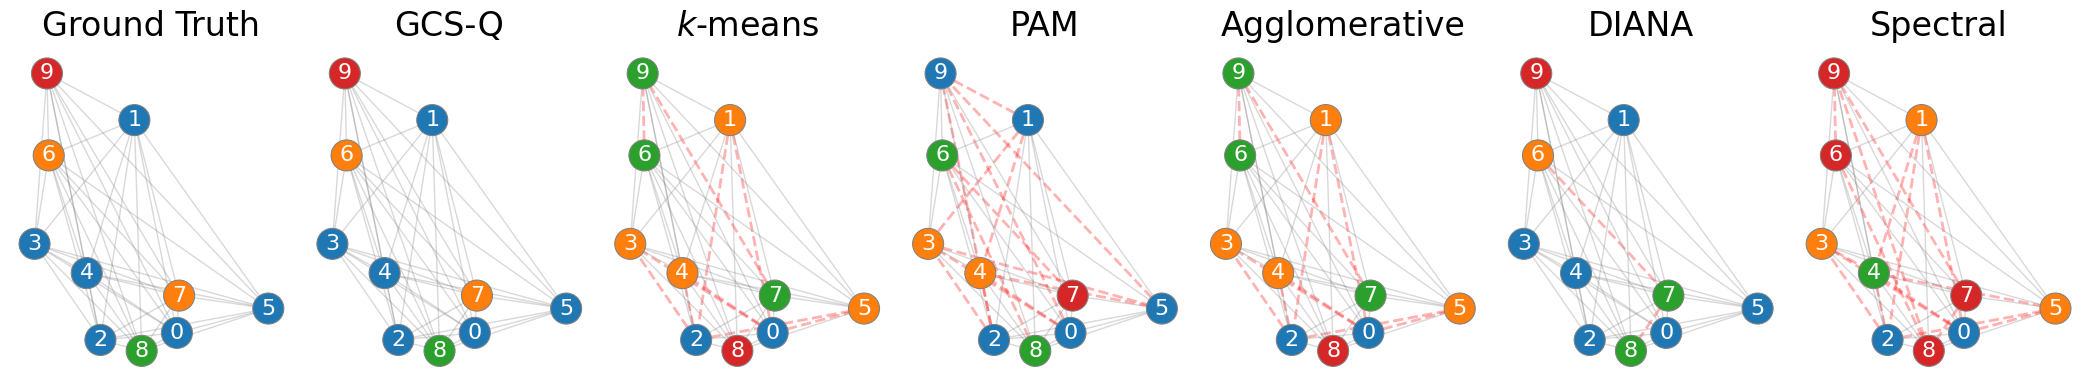

In [16]:
G = nx.complete_graph(adj_matrix.shape[0])
pos = nx.random_layout(G, seed=111)
# pos = nx.circular_layout(G)

plot_clusters_graph(adj_matrix, clustering_dict, pos)